<a href="https://colab.research.google.com/github/hildj/DS3001_TeamM_Project/blob/main/linearregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Regression: Mortality ~ Hospital Ratings ===

                                    OLS Regression Results                                   
Dep. Variable:     Q('Risk Adjusted Mortality Rate')   R-squared:                       0.114
Model:                                           OLS   Adj. R-squared:                  0.114
Method:                                Least Squares   F-statistic:                     57.73
Date:                               Wed, 19 Nov 2025   Prob (F-statistic):           3.84e-25
Time:                                       03:29:28   Log-Likelihood:                -6271.3
No. Observations:                               2126   AIC:                         1.255e+04
Df Residuals:                                   2123   BIC:                         1.257e+04
Df Model:                                          2                                         
Covariance Type:                                 HC3                                         
         

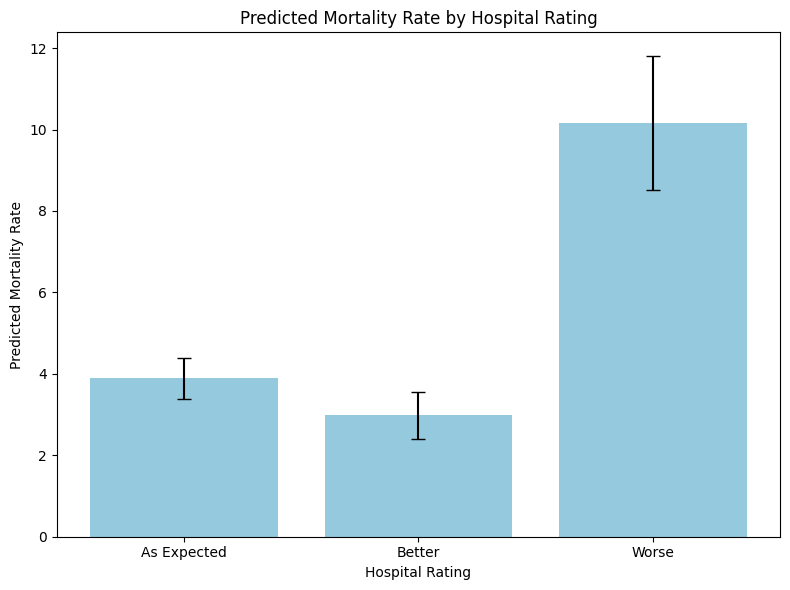

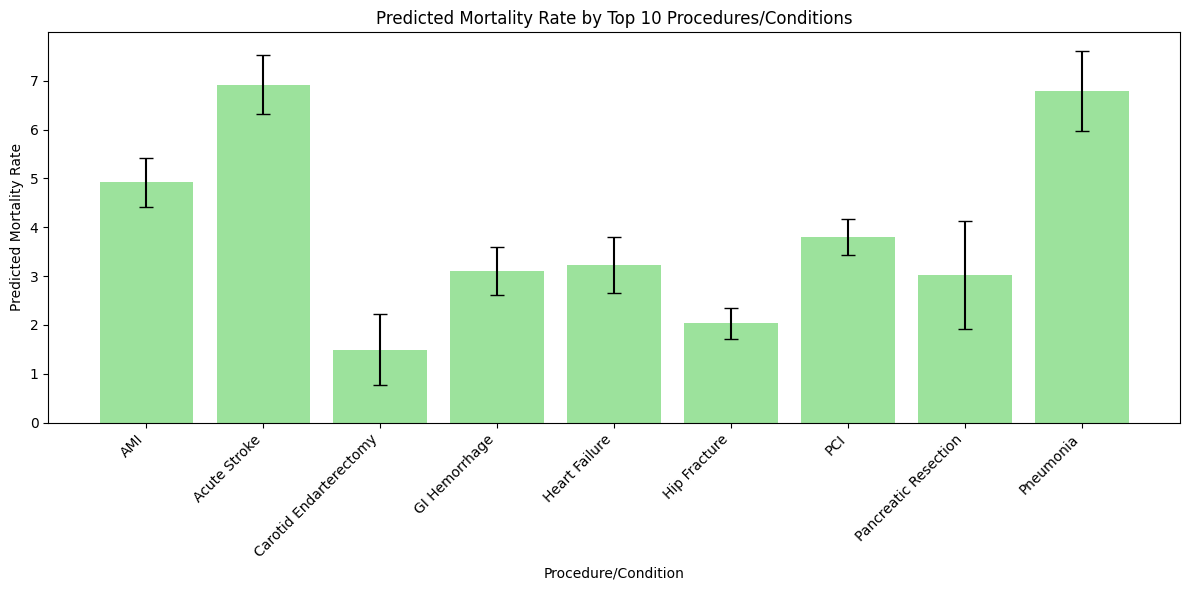

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

# load and clean data
df = pd.read_csv("hospital data cleaned.csv")

# strip whitespace from column names
df.columns = df.columns.str.strip()

# rename columns
df = df.rename(columns={
    'Procedure': 'Procedure/Condition',
    'Risk Adjuested Mortality Rate': 'Risk Adjusted Mortality Rate'
})

# 1. mortality ~ hospital ratings
model_rating = smf.ols(
    formula="Q('Risk Adjusted Mortality Rate') ~ C(Q('Hospital Ratings'))",
    data=df
).fit(cov_type="HC3")

# 2. mortality ~ procedure/condition
model_condition = smf.ols(
    formula="Q('Risk Adjusted Mortality Rate') ~ C(Q('Procedure/Condition'))",
    data=df
).fit(cov_type="HC3")

# 3. combined model: mortality ~ ratings + condition
model_combined = smf.ols(
    formula="Q('Risk Adjusted Mortality Rate') ~ C(Q('Hospital Ratings')) + C(Q('Procedure/Condition'))",
    data=df
).fit(cov_type="HC3")

print("\n=== Regression: Mortality ~ Hospital Ratings ===\n")
print(model_rating.summary())

print("\n=== Regression: Mortality ~ Procedure/Condition ===\n")
print(model_condition.summary())

print("\n=== Regression: Mortality ~ Hospital Ratings + Procedure/Condition ===\n")
print(model_combined.summary())

# get predicted values with 95% confidence intervals
pred = model_combined.get_prediction(df)
pred_summary = pred.summary_frame(alpha=0.05)  # 95% CI

df['predicted'] = pred_summary['mean']
df['ci_lower'] = pred_summary['mean_ci_lower']
df['ci_upper'] = pred_summary['mean_ci_upper']

# average predicted mortality by hospital ratings
rating_summary = df.groupby('Hospital Ratings').agg(
    predicted_mean=('predicted', 'mean'),
    ci_lower=('ci_lower', 'mean'),
    ci_upper=('ci_upper', 'mean')
).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='Hospital Ratings', y='predicted_mean', data=rating_summary, color='skyblue')
plt.errorbar(x=np.arange(len(rating_summary)),
             y=rating_summary['predicted_mean'],
             yerr=[rating_summary['predicted_mean'] - rating_summary['ci_lower'],
                   rating_summary['ci_upper'] - rating_summary['predicted_mean']],
             fmt='none', c='black', capsize=5)
plt.ylabel("Predicted Mortality Rate")
plt.xlabel("Hospital Rating")
plt.title("Predicted Mortality Rate by Hospital Rating")
plt.tight_layout()
plt.show()

# average predicted mortality by top 10 procedures/conditions
top_conditions = df['Procedure/Condition'].value_counts().nlargest(10).index
condition_summary = df[df['Procedure/Condition'].isin(top_conditions)].groupby('Procedure/Condition').agg(
    predicted_mean=('predicted', 'mean'),
    ci_lower=('ci_lower', 'mean'),
    ci_upper=('ci_upper', 'mean')
).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='Procedure/Condition', y='predicted_mean', data=condition_summary, color='lightgreen')
plt.errorbar(x=np.arange(len(condition_summary)),
             y=condition_summary['predicted_mean'],
             yerr=[condition_summary['predicted_mean'] - condition_summary['ci_lower'],
                   condition_summary['ci_upper'] - condition_summary['predicted_mean']],
             fmt='none', c='black', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Predicted Mortality Rate")
plt.xlabel("Procedure/Condition")
plt.title("Predicted Mortality Rate by Top 10 Procedures/Conditions")
plt.tight_layout()
plt.show()
